---

## Big Picture: What the Code is Doing**

This code is:

1. Defining the *geometry* of the pendulum path (`x(theta), y(theta)`).
2. Using **Lagrangian mechanics** to get the equations of motion.
3. Numerically solving those equations with `odeint`.
4. Converting the solution into a visual animation.

The big advantage here is:

> Instead of writing Newton’s force equations directly, we let the Lagrangian (`L = T - V`) generate the motion equations for us.

This makes it **much easier** to generalize to more complicated systems — especially in higher dimensions.

---

In [50]:
import numpy as np
from scipy.integrate import odeint
import sympy as smp
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

---

### **Variables and Setup**

```python
t, m, g = smp.symbols('t m g')
theta = smp.symbols(r'\theta', cls=smp.Function)
theta = theta(t)
```

* `t` = time, `m` = mass, `g` = gravity.
* `theta(t)` is the generalized coordinate (angle in this case).
* We treat `theta` as a **function of time**, so Sympy can take derivatives wrt `t`.

---

In [51]:
t, m, g = smp.symbols('t m g')
theta = smp.symbols(r'\theta', cls=smp.Function)
theta = theta(t)

In [52]:
d_theta  = smp.diff(theta, t)
dd_theta = smp.diff(d_theta, t)

In [53]:
x, y = smp.symbols('x y', cls=smp.Function)
x, y = x(theta), y(theta)

---

### **Parametrizing the Path**

* This defines **how the mass moves in space** based on `theta`.
* Here, you’re free to make the constraint curve *anything*: a parabola, a taut chain shape, etc.
* This is powerful because the rest of the code **does not care** about the curve — it just uses these functions to compute energies.

---

In [54]:
local = 'taut'
if local == 'parabola':
    x = theta
    y = theta ** 2
elif local == 'taut':
    x = smp.sin(2 * theta) + 2 * theta
    y = 1 - smp.cos(2 * theta)
x_func = smp.lambdify(theta, x)
y_func = smp.lambdify(theta, y)

---

### **Kinetic & Potential Energy**
* **T**: Kinetic energy = $\frac{1}{2} m (v_x^2 + v_y^2)$ —
  where $v_x, v_y$ are computed via the chain rule:
  $v_x = \frac{dx}{d\theta} \cdot \frac{d\theta}{dt}$
* **V**: Potential energy = $m g y$ (assuming y is vertical height).
* **L**: Lagrangian = $T - V$.

This is *the* Lagrangian mechanics approach:
We don’t directly write $F = ma$, we use $L = T - V$ to get the motion.

---

In [55]:
T = 0.5 * m * (smp.diff(x, t)**2 + smp.diff(y, t)**2)
V = m * g * y
L = T - V

---

## **What is Lagrangian Mechanics?**

### **The Short Story**

Lagrangian mechanics is a way of describing how physical systems evolve over time using **energies** instead of **forces**.

Instead of saying:

$$
F = ma
$$

we say:

$$
L = T - V
$$

where:

* $T$ = kinetic energy
* $V$ = potential energy

and then apply **Lagrange’s equation**:

$$
\frac{\partial L}{\partial q} - \frac{d}{dt}\left( \frac{\partial L}{\partial \dot{q}} \right) = 0
$$

Here:

* $q$ is a *generalized coordinate* (could be an angle, a distance along a curve, etc.).
* $\dot{q}$ is its time derivative.

---

### **Why This Is Powerful**

* You **don’t** have to write down every force vector and resolve them into components.
* You can use *any coordinate system* (angles, curvy paths, arc lengths, etc.).
* The math automatically respects **constraints** (like a bead sliding on a wire, or a pendulum constrained to a circle).

For example:

* A pendulum’s bob moves in a circle — that’s a **constraint**.
* In Newton’s $F=ma$, you’d have to deal with the tension force, resolve it into radial/tangential components, and eliminate the radial motion by hand.
* In Lagrangian mechanics, you skip all that: you just say “The bob moves along this path” and let the Lagrangian formalism take care of the constraint for you.

---

### **Lagrange’s Equation**

The standard Lagrange equation is:

$$
\frac{\partial L}{\partial \theta} - \frac{d}{dt} \frac{\partial L}{\partial \dot{\theta}} = 0
$$

Your code rearranges this to find $\ddot{\theta}$ in terms of $\theta$ and $\dot{\theta}$.

---

In [56]:
LEQ = smp.diff(L, theta) - smp.diff(smp.diff(L, d_theta), t)

In [58]:
second_d = smp.solve(LEQ, dd_theta)[0]
first_d = d_theta
second_d_func = smp.lambdify((g, theta, d_theta), second_d)
first_d_func = smp.lambdify(d_theta, d_theta)

---

`dSdt` is the **heart of the numerical simulation** — it’s the “time derivative function” that the numerical integrator (`odeint`) uses to march the solution forward.

---

## **What `dSdt` Represents**

In the code:

```python
def dSdt(S, t):
    return [
        first_d_func(S[1]),                 # d(theta)/dt = angular velocity
        second_d_func(g, S[0], S[1])        # d^2(theta)/dt^2 = angular acceleration
    ]
```

* `S` is the **state vector**:

  $$
  S[0] = \theta(t) \quad \text{(position)}
  $$

  $$
  S[1] = \dot{\theta}(t) \quad \text{(velocity)}
  $$
* `dSdt(S, t)` returns the **derivative of the state vector**:

  $$
  \frac{d}{dt}S =
  \begin{bmatrix}
  \dot{\theta} \\ \ddot{\theta}
  \end{bmatrix}
  $$
* This is exactly the form `odeint` (and most ODE solvers) require:

  $$
  \frac{d\mathbf{S}}{dt} = f(\mathbf{S}, t)
  $$

---

## **Why We Need It**

`odeint` does **not** magically know how the pendulum moves — it just knows how to numerically integrate:

* Give it a current state $S(t)$
* It calls the `dSdt` function to find the derivative
* It then takes a small time step to $S(t+\Delta t)$
* Repeats until the whole trajectory is computed.

If `dSdt` is wrong or missing, the integrator has nothing to work with.

Think of `dSdt` as the **“physics engine” interface**:
We write the laws of motion, and the integrator takes care of solving them over time.

---
### **Numerical Solver Setup**

Here:

* `S[0] = theta`
* `S[1] = d_theta/dt`
* The system is rewritten as a **first-order system** for `odeint`.

---

In [59]:
def dSdt(S, t):
    return [
        first_d_func(S[1]), second_d_func(g, S[0], S[1])
    ]

---
### **Solving**

* `odeint` numerically integrates the equations of motion.
* The result is the time evolution of `theta` and `d_theta/dt`.

---

In [60]:
t = np.linspace(0, 20, 1000)
g = 9.81

if local == 'parabola':
    answer = odeint(dSdt, y0 = [2, 0], t = t)
elif local == 'taut':
    answer = odeint(dSdt, y0 = [np.pi/4, 0], t = t)

In [62]:
def get_xy(theta):
    return x_func(theta), y_func(theta)

---
### **Converting Back to x, y**

Since we solved for `theta(t)`, we can plug it into the earlier `x(theta)` and `y(theta)` to get actual coordinates.

---

In [63]:
x, y = get_xy(answer.T[0])

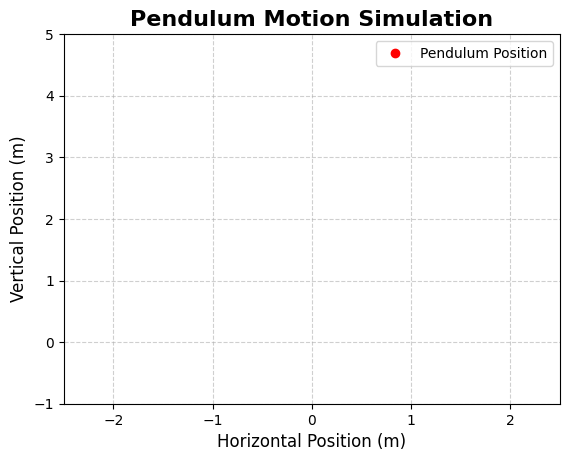

In [64]:
def animate(i):
    ln.set_data([x[i]], [y[i]])

fig, ax = plt.subplots()

ax.grid(True, linestyle='--', alpha=0.6)
ln, = plt.plot([], [], 'ro', label='Pendulum Position')

ax.set_title('Pendulum Motion Simulation', fontsize=16, fontweight='bold')
ax.set_xlabel('Horizontal Position (m)', fontsize=12)
ax.set_ylabel('Vertical Position (m)', fontsize=12)

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-1, 5)

ax.legend(loc='upper right')

ani = animation.FuncAnimation(fig, animate, frames = 1000, interval = 50)
ani.save(f'PENDULUM_{local}.gif', writer='pillow', fps = 50)

---
## **Different Mechanics**

Lagrangian mechanics is not the only way.

### **(a) Newton’s Laws (Force-Based)**

$$
\mathbf{F} = m \mathbf{a}
$$

* You write force vectors for each object.
* Resolve into components in your chosen coordinates.
* Include constraint forces (e.g., tension).
* Good for simple systems in Cartesian coordinates.
* **Downside:** Becomes messy with constraints and non-Cartesian coordinates.

---

### **(b) Hamiltonian Mechanics**

* Starts from $H = T + V$ (total energy) and uses **canonical coordinates** $(q, p)$ (generalized position & momentum).
* Produces **first-order** equations instead of second-order ones.
* Useful in advanced physics (quantum mechanics, statistical mechanics).
* Often overkill for basic simulations unless you need its special properties.

---

### **(c) Direct Constraint Approach**

* Write down acceleration purely from geometry (using polar coords, rotation matrices, etc.).
* Example: For a pendulum, you can write:

  $$
  \ddot{\theta} = -\frac{g}{L} \sin\theta
  $$

  directly from Newton’s laws.
* This is fast, but **not general** — you have to re-derive for every new geometry.

---

### **(d) Numerical-Only “Black Box”**

* Skip analytical derivation; numerically approximate derivatives from the geometry + forces.
* Example: Verlet integration in game physics engines.
* **Upside:** Quick for prototyping.
* **Downside:** Less precise, less insight into actual physics.

---

| Method              | Works well for                          | Pain points                           |
| ------------------- | --------------------------------------- | ------------------------------------- |
| **Newton’s laws**   | Few bodies, simple forces               | Hard with constraints or curvy coords |
| **Lagrangian**      | Arbitrary coords, constrained systems   | Needs $T, V$ (energy forms)           |
| **Hamiltonian**     | Energy conservation, symplectic methods | Abstract, more math overhead          |
| **Direct geometry** | Simple systems with known formula       | Not generalizable                     |
| **Numerical-only**  | Games, approximate sims                 | Less physically rigorous              |

---
